In [169]:
#import all necessary libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import matplotlib.style as stl 
stl.use('fivethirtyeight')

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import  RandomForestClassifier

import xgboost as xgb 

In [170]:
train = pd.read_csv('../data/modulbank_train.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/modulbank_test.csv', sep='\t', index_col=0 )

In [171]:
const_columns = ['9', '140', '164'] 
const_in_test_1 = ['11']
const_in_test = ['5', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305']
zero_train_features = ['152', '160']


def preprocess(train_df, test_df):
    train = train_df.drop(const_columns, axis=1)
    test = test_df.drop(const_columns, axis=1)
    
    for column in const_in_test:
        train = train[train[column] == 0].drop(column, axis=1)
        test.drop(column, axis=1, inplace=True)
        
    for column in const_in_test_1:
        train = train[train[column] == 1].drop(column, axis=1)
        test.drop(column, axis=1, inplace=True)
        
    X_train = train.drop('0', axis=1).reset_index(drop=True)
    y_train = train['0'].reset_index(drop=True)
    X_test = test.drop('0', axis=1).reset_index(drop=True)
    return X_train, y_train, X_test

xtrain, ytrain, xtest = preprocess(train, test)

In [172]:
#for getting predictions of an estimator for test and train folds 
def get_results(estimator, skf, xtrain, ytrain, xtest):
    estimator.fit(xtrain, ytrain)
    predictions = estimator.predict_proba(xtest)[:, 1]
    
    predictions_cv = []
    k = 0
    for train_idx, val in skf.split(xtrain, ytrain):
        k+=1
        print(f"Fittng {k} fold")
        estimator.fit(xtrain.iloc[train_idx], ytrain.iloc[train_idx])
        predictions_cv.append([ytrain.iloc[val], estimator.predict_proba(xtrain.iloc[val])[:,1]])

    return predictions, predictions_cv

In [173]:
#writing submissions to file 
def to_submission(predictions, filename):
    seria = pd.Series(predictions, name='_VAL_')
    seria.to_csv(filename, header=True, index_label='_ID_')

In [174]:
#cross-validation
skf = StratifiedKFold(n_splits=8, random_state=42)

### FEATURE ENGINEERING (XGBOOST  AS  A TEST MODEL ) 

####  BASELINE (BEST XGB MODEL WITH BASE FEATURE PREPROCESS), learning rate = 0.03
(for faster training)

In [175]:
params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.03,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}
n_rounds = 10000
xgb_train = xgb.DMatrix(xtrain, ytrain)
results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
base_xgb = results['test-auc-mean'].iloc[-1]
print(f"CV roc auc for  xgboost {base_xgb}")

CV roc auc for  xgboost 0.7397753333333333


#####  top BASELINE (BEST XGB MODEL WITH BASE FEATURE PREPROCESS), learning rate = 0.01

In [40]:
params_xgb_01 = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}
n_rounds = 10000
xgb_train = xgb.DMatrix(xtrain, ytrain)
results = xgb.cv(params_xgb_01,  xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
base_xgb_01 = results['test-auc-mean'].iloc[-1]
print(f"CV roc auc for  xgboost {base_xgb_01}")

CV roc auc for  xgboost 0.7424143333333334


####  DIMENSIONALITY REDUCTION

1. PCA 

In [21]:
from sklearn.decomposition import PCA 

In [22]:
pca = PCA(n_components=200)
xreduced = pca.fit_transform(xtrain)

In [28]:
#reduce n_features 
for n_components in range(80, 330, 30):
    pca = PCA(n_components=n_components)
    xreduced = pca.fit_transform(xtrain)
    xgb_train = xgb.DMatrix(xreduced, ytrain)
    results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
    score = results['test-auc-mean'].iloc[-1]
    print(f"{n_components}: {score}, diff: {round(score - base_xgb, 5)}")

80: 0.7275526666666666, diff: -0.01222
110: 0.7296016666666666, diff: -0.01017
140: 0.7316126666666666, diff: -0.00816
170: 0.7322163333333332, diff: -0.00756
200: 0.7314466666666667, diff: -0.00833
230: 0.7320483333333333, diff: -0.00773
260: 0.731537, diff: -0.00824
290: 0.7314393333333333, diff: -0.00834
320: 0.730414, diff: -0.00936


In [36]:
for n_components in range(1, 6):
    pca = PCA(n_components=n_components)
    xreduced = pca.fit_transform(xtrain)
    xgb_train = xgb.DMatrix(np.hstack([xtrain, xreduced]), ytrain)
    results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
    score = results['test-auc-mean'].iloc[-1]
    print(f"added reduced features as {n_components} new features : {score}, diff: {round(score - base_xgb, 5)}")

added reduced features as 1 new features : 0.741482, diff: 0.00171
added reduced features as 2 new features : 0.7416490000000001, diff: 0.00187
added reduced features as 3 new features : 0.741355, diff: 0.00158
added reduced features as 4 new features : 0.7399643333333333, diff: 0.00019
added reduced features as 5 new features : 0.7402846666666667, diff: 0.00051


In [44]:
#adding reduced features as new 
pca = PCA(n_components=2)
xreduced = pca.fit_transform(xtrain)

xgb_train = xgb.DMatrix(np.hstack([xtrain, xreduced]), ytrain)
results = xgb.cv(params_xgb_01, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
score = results['test-auc-mean'].iloc[-1]
print(f"added reduced features as 2 new features : {score}, diff: {round(score - base_xgb_01, 5)}")

added reduced features as 2 new features : 0.7431266666666666, diff: 0.00071


In [176]:
xtrain['pca1'] = xreduced[:, 0]
xtrain['pca2'] = xreduced[:, 1]

####  CLUSTERING


umap +dbscan

In [139]:
from sklearn.cluster import DBSCAN
import umap

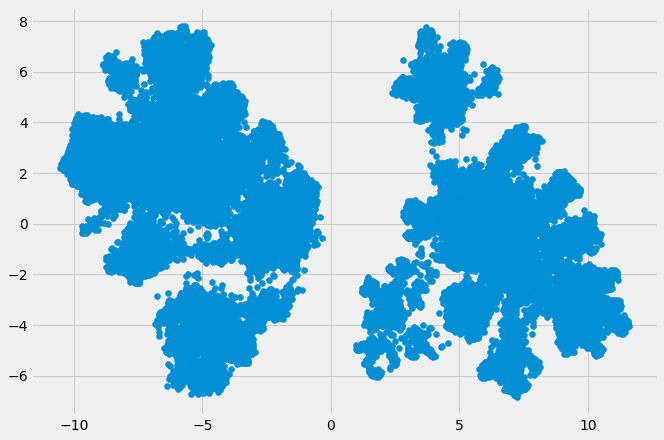

In [145]:
plt.rcParams['figure.figsize'] = 10, 7
embedding = umap.UMAP(n_neighbors=25,
                      min_dist=0.5,
                      metric='correlation').fit_transform(xtrain)

plt.scatter(embedding[:, 0], embedding[:, 1])

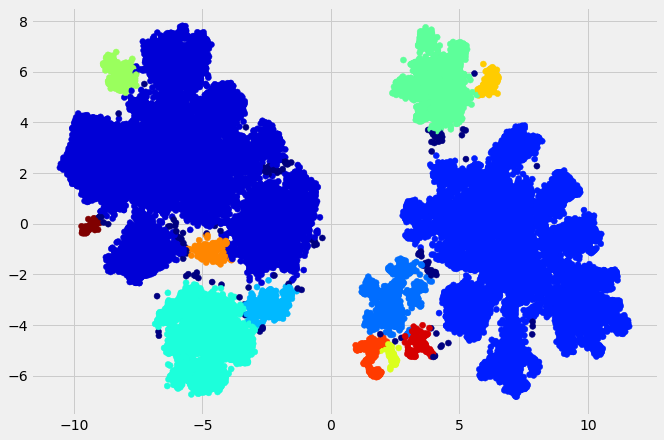

In [148]:
db = DBSCAN(
    eps=0.37,
    min_samples=50,
    n_jobs=-1,
)

cluster_labels = db.fit_predict(embedding)
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='jet')

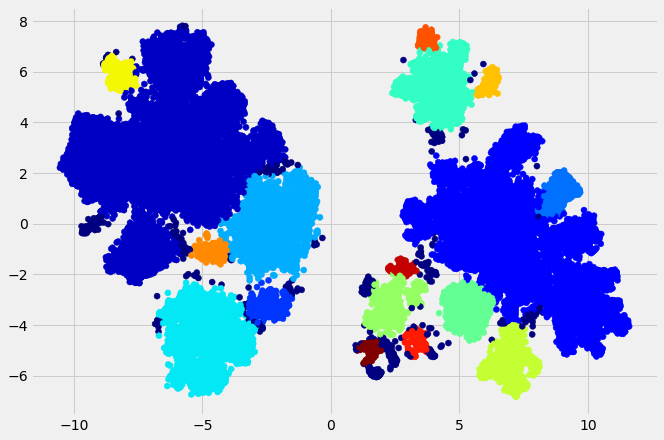

In [165]:
db = DBSCAN(
    eps=0.45,
    min_samples=100,
    n_jobs=-1,
)

cluster_labels = db.fit_predict(embedding)
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='jet')

In [151]:
xgtrain = xtrain.copy()
xgtrain['clusters'] = cluster_labels
xgb_train = xgb.DMatrix(xgtrain, ytrain)
results = xgb.cv(params_xgb_01, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
score = results['test-auc-mean'].iloc[-1]
print(f"added cluster labels as new feature : {score}, diff: {round(score - base_xgb_01, 5)}")

added cluster labels as new feature : 0.7423173333333333, diff: -0.0001


####  FEATURE SELECTION 

1. SELECTKBEST

In [189]:
ks = np.arange(170, 330, 10)
k_xgb_scores = []
for k in ks:

    x_data_kbest = SelectKBest(f_classif, k=k).fit_transform(xtrain, ytrain)
    xgb_train = xgb.DMatrix(x_data_kbest, ytrain)

    nrounds = 10000
    results_ = xgb.cv(params_xgb_01, xgb_train, num_boost_round=nrounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
    k_xgb_scores.append(results_['test-auc-mean'].iloc[-1])

In [187]:
ks[np.argmax(k_xgb_scores)]

310

In [188]:
x_data_kbest = SelectKBest(f_classif, k=310).fit_transform(xtrain, ytrain)
xgb_train = xgb.DMatrix(x_data_kbest, ytrain)
results_ = xgb.cv(params_xgb_01, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
score = results_['test-auc-mean'].iloc[-1]

print(f"Score with selectkbest :{score}, diff: {round(score - base_xgb_01, 5)}")

Score with selectkbest :0.742827, diff: 0.00041


In [ ]:
#mutual_info_classif - works but worse than f_classif
from sklearn.feature_selection import mutual_info_classif
ks = np.arange(30, 320, 10)
k_scores_m = []
for k in ks:
    x_data_kbest = SelectKBest(mutual_info_classif, k=k).fit_transform(xtrain, ytrain)
    k_scores_m.append(cross_val_score(LogisticRegression(random_state=42), x_data_kbest, ytrain, cv=skf, scoring='roc_auc').mean())

2.SELECTFROMMODEL

In [119]:
rf = RandomForestClassifier(criterion='entropy', max_depth=20, max_features=0.2, min_samples_leaf=10, 
                            min_samples_split=2, n_estimators=75, n_jobs=4, random_state=42)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [138]:
tiles = [pd.Series(rf.feature_importances_).quantile(x) for x in np.arange(0,60, 5)*0.01][6:]
for t in tiles :

    data = SelectFromModel(estimator=rf, threshold=t).fit_transform(xtrain, ytrain)
    
    xgb_train = xgb.DMatrix(data, ytrain)
    results_ = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
    cv_score = results_['test-auc-mean'].iloc[-1]
   
    print(f"{t} :    {cv_score}, diff:  {round(cv_score - base_xgb, 5)}")

1.9446314666607918e-05 :    0.7398906666666667, diff:  0.00012
4.313638846547614e-05 :    0.73976, diff:  -2e-05
8.238937115409498e-05 :    0.7406036666666665, diff:  0.00083
0.0001406956748153087 :    0.7398979999999998, diff:  0.00012
0.0002701789715489331 :    0.7402253333333334, diff:  0.00045
0.0005478823586112388 :    0.7404310000000001, diff:  0.00066


####  TARGET ENCODING

In [49]:
num_cols = [col for col in xtrain if xtrain[col].nunique() > 2 ]
bin_cols = [col for col in xtrain if xtrain[col].dropna().value_counts().index.isin([0,1]).all()]

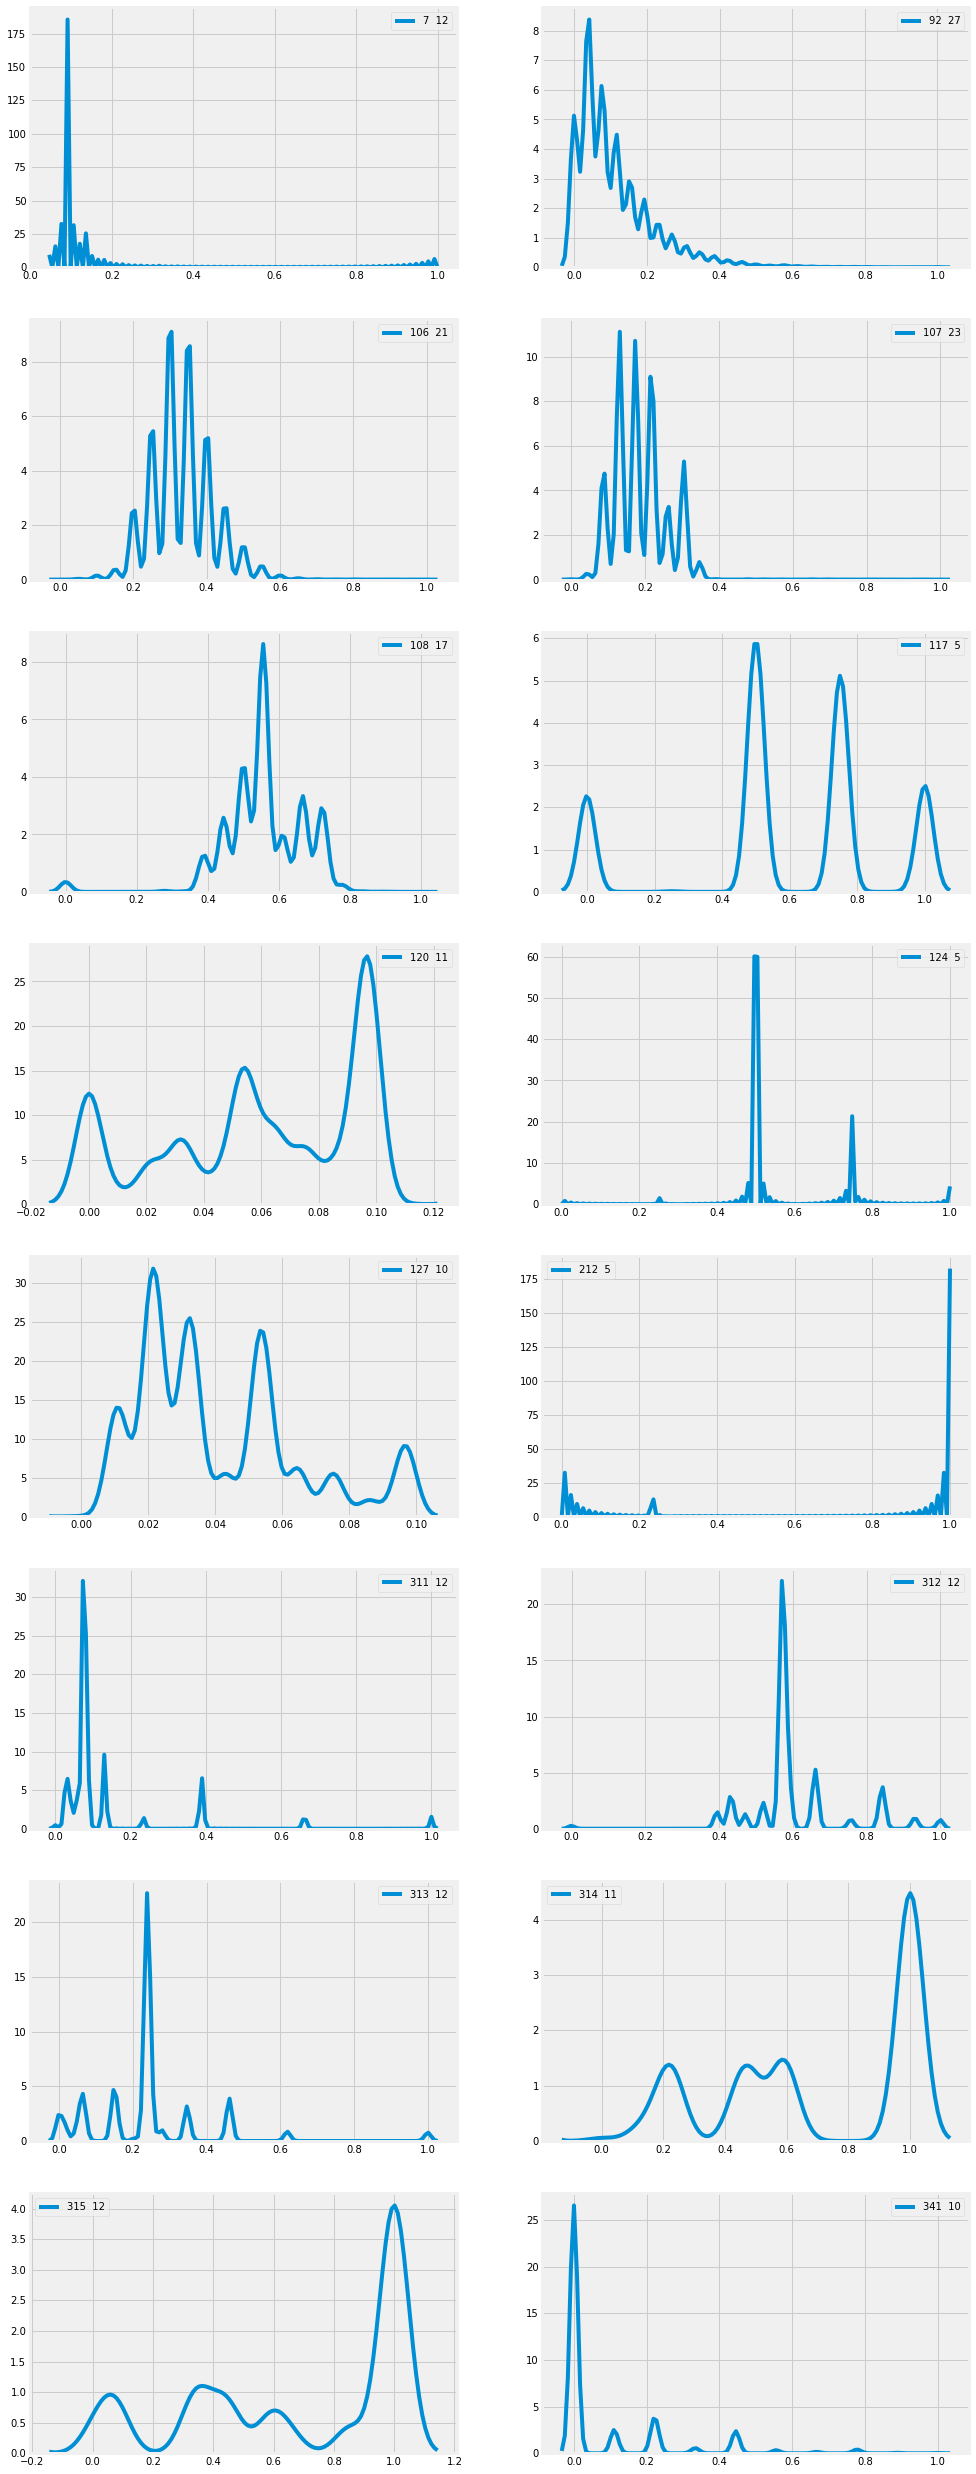

In [50]:
#some numerical features might been categorigal
num_cols = [col for col in xtrain if xtrain[col].nunique() > 2 and xtrain[col].nunique() < 32 ]
plt.rcParams['figure.figsize'] = 15, 45

fig, ax = plt.subplots(nrows=8, ncols=2)

i = 0
for row in ax:
    for col in row:
        n_values = xtrain[num_cols[i]].nunique()
        sns.kdeplot(xtrain[num_cols[i]],ax=col, label=num_cols[i]+"  " + str(n_values) )
        i += 1


In [51]:
#1_2_3 = results of one hot encoding 
xtrain[['1', '2', '3']].sum(axis=1).value_counts(normalize=True)

1    1.0
dtype: float64

In [54]:
xgtrain = xtrain.copy()
def remove_ohe(row):
    if row['1'] == 1:
        return 1 
    elif row['2'] == 1:
        return 2
    elif row['3'] == 1:
        return 3
    else:
        return 0 

xgtrain['1_2_3'] = xgtrain.apply(lambda row : remove_ohe(row), axis=1) 
xgtrain.drop(['1', '2', '3'], axis = 1, inplace=True )


In [55]:
num_cols += ['1_2_3']

In [52]:
# by Stas Semenov

import time


class SemenovEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data
        
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    normalni_y = []
    se = SemenovEncoding()
    new_skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    val_dfs = []

    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):

        se.fit(
            new_train.iloc[new_train_split], 
            new_train_y.iloc[new_train_split], 
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
        normalni_y.append(new_train_y.iloc[new_val_split])

    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val, normalni_y       

In [78]:
new_train_dfs = []
new_val_dfs = []

new_y_train_dfs = []
new_y_val_dfs = []

main_train_dfs = []

for train_split, val_split in skf.split(xgtrain, ytrain): 

    temp_train_dfs, temp_val_df, temp_y_train_dfs = create_new_df_with_categorical_encodings(
        xgtrain.iloc[train_split], 
        ytrain.iloc[train_split], 
        xgtrain.iloc[val_split], 
        num_cols
    )

    new_y_train_dfs.append(temp_y_train_dfs)
    new_y_val_dfs.append(ytrain.iloc[val_split])
    
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)

    se = SemenovEncoding()
    se.fit(xgtrain.iloc[train_split], ytrain.iloc[train_split], num_cols)
    main_train_dfs.append(
        se.transform(xgtrain.iloc[val_split], inplace=False)
    )
    

new_train_dfs = [pd.concat(i, axis=0, ignore_index=True) for i in new_train_dfs]
new_y_train_dfs = [pd.concat(i, axis=0, ignore_index=True) for i in new_y_train_dfs]


k= 0
scores = []
for tr, y_tr, val, y_val in zip(new_train_dfs, new_y_train_dfs, new_val_dfs, new_y_val_dfs):
    
    k+=1
    xgb_train = xgb.DMatrix(tr, y_tr)
    xgb_test = xgb.DMatrix(val)
    xgb_model = xgb.train(params_xgb_01, xgb_train, len(results))
    xgb_predictions = xgb_model.predict(xgb_test)
    score = roc_auc_score( y_val , xgb_predictions)
    scores.append(score)
    print(f"On {k} Fold : {score}")
print(f"CV {np.mean(scores)}, diff with best_xgb: {round(np.mean(scores) - base_xgb_01, 5)}")

On 1 Fold : 0.7434360654867727
On 2 Fold : 0.7409863765072457
On 3 Fold : 0.7474872919422766
On 4 Fold : 0.7666576506038388
On 5 Fold : 0.7389190215199184
On 6 Fold : 0.7422231712814672
On 7 Fold : 0.7524202831476141
On 8 Fold : 0.7516527228927099
CV 0.7479728229227304, diff with best_xgb: 0.00556


####  XGBFIR USAGE

In [79]:
import xgbfir

In [81]:
xgb_train = xgb.DMatrix(xtrain, ytrain)
xgb_model = xgb.train(params_xgb, xgb_train, len(results))
xgbfir.saveXgbFI(xgb_model)

In [90]:
xgtrain = xtrain.copy()
xgtrain['165_337'] = np.sqrt( xgtrain['165'] * xgtrain['337'] )

xgtrain.drop(['337'], axis=1, inplace=True)
xgtrain.drop(['165'], axis=1, inplace=True)

xgtrain['339_34'] = np.sqrt( xgtrain['339'] * xgtrain['34'] )
xgtrain.drop(['34'], axis=1, inplace=True)

In [88]:
xgb_train = xgb.DMatrix(xgtrain, ytrain)
results = xgb.cv(params_xgb_01, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
score = results['test-auc-mean'].iloc[-1]
print(f"Score with xgbfir : {score}, diff: {round(score - base_xgb_01, 5)}")

Score with xgbfir : 0.7431966666666666, diff: 0.00078
